# **CNN Training and Testing**

this notebook showcases the experiments with different CNN architectures using as input data the mel spectrogram matrices

## Environment Set Up

importing the necessary libraries and loading the extracted data into the notebook, checking to see if everything is as intended

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
tf.keras.backend.clear_session()

In [4]:
file_name = "/content/gdrive/MyDrive/fold_pointers_v2"
file_object = open(file_name,'rb')
fold_pointers = pickle.load(file_object)

In [5]:
fold_pointers

array([   1,  874, 1762, 2687, 3677, 4613, 5436, 6274, 7073, 7889, 8726],
      dtype=int32)

In [6]:
file_name = "/content/gdrive/MyDrive/labels_v2"
file_object = open(file_name,'rb')
labels = pickle.load(file_object)

In [7]:
labels = np.array(labels)
labels

array([3, 3, 3, ..., 4, 4, 4])

In [8]:
labels.shape

(8725,)

In [9]:
file_name = "/content/gdrive/MyDrive/spec_data_v2"
file_object = open(file_name,'rb')
spec_data = pickle.load(file_object)

In [10]:
spec_data[0]

array([[9.22176187e-05, 2.03987947e-05, 5.12364022e-05, ...,
        7.59018178e-04, 2.88242823e-04, 6.12167222e-03],
       [8.59618740e-05, 5.33761224e-04, 2.80186767e-03, ...,
        2.79585971e-03, 8.13090475e-04, 1.35818226e-02],
       [6.88650398e-05, 1.67922862e-03, 9.83259268e-03, ...,
        4.44085430e-03, 1.35617773e-03, 3.22338194e-02],
       ...,
       [7.02667835e-09, 1.65571450e-08, 2.09187299e-08, ...,
        1.71099472e-08, 2.24688979e-08, 1.74187116e-05],
       [1.32673605e-09, 1.98949079e-09, 3.70710529e-09, ...,
        1.98543515e-09, 2.45731036e-09, 1.06137295e-05],
       [2.01663367e-10, 5.07661482e-11, 7.21811777e-11, ...,
        4.01841234e-11, 5.86211149e-11, 6.93119364e-06]])

In [11]:
spec_data.shape

(8725, 128, 173)

In [12]:
spec_data = np.expand_dims(spec_data, axis = 3)

In [13]:
spec_data.shape

(8725, 128, 173, 1)

In [14]:
spec_data_channels = np.repeat(spec_data, 3, axis = 3)

since we are attempting to train various VGG networks, which are built for images, we have to reshape the input to include 3 channels (which would be an image's RGB channels). We do this by simply repeating the spectrogram matrix along the third axis

In [15]:
spec_data_channels.shape

(8725, 128, 173, 3)

## Defining Model History

defining a class to store and access model history

In [16]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

# **Architecture Experimentation**

- we start by experiment with different kinds of models and layer configurations in an attempt to more intuitively understand how they might behave and what changes we might need to make to obtain greater performance
- at this stage, we are only attempting to run as many empiricial tests as possible and not trying to optimize generalization of our problem: this is the first step

## Pre-trained VGG16 (ImageNet)

- In order to understand what we can expect from the VGG Model, we start by applying a pre-trained model directly on our data.
We used the VGG16 model available on tensorflow and selected the ImageNet weights.
- Since our model was trained on RGB images, it expects our input to have 3 channels. To avoid this problem, we simply repeat the same spectrogram matrix 3 times along the correct axis.
- As for the ouput, the network also does not expect 10 output classes, as this is not the case for the ImageNet dataset, so we have to manually define the fully-connected layers at the top of the network.

In [ ]:
import tensorflow
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras import backend as K

imagenet_weights = VGG16(weights='imagenet', include_top=False, input_shape=(128,173,3))
imagenet_weights.summary(line_length=150)

flatten = Flatten()
new_layer2 = Dense(10, activation='softmax', name='dense2')

input2 = imagenet_weights.input
output2 = new_layer2(flatten(imagenet_weights.output))

pretrained_VGG16 = Model(input2, output2)
pretrained_VGG16.summary()

Model: "vgg16"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_5 (InputLayer)                                              [(None, 128, 173, 3)]                                       0                      
                                                                                                                                                      
 block1_conv1 (Conv2D)                                             (None, 128, 173, 64)                                        1792                   
                                                                                                                                                      
 block1_conv2 (Conv2D)                                             (None, 128, 

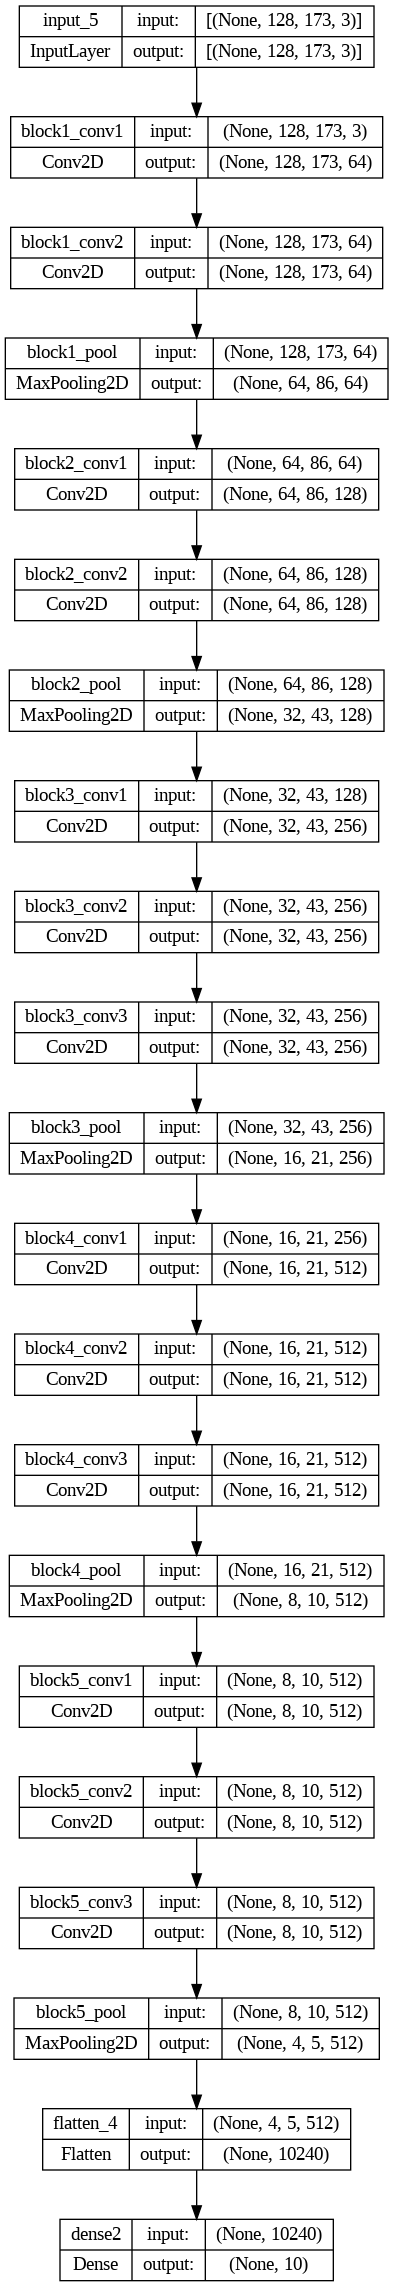

In [ ]:
tf.keras.utils.plot_model(pretrained_VGG16, show_shapes=True)

In [ ]:
pretrained_VGG16.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

- we test the network on each fold of the data using the pre-trained ImageNet weights. The results were very far fromm intended, in some cases even worse than baseline (10%).

In [ ]:
evaluation = {}

for i in range(len(fold_pointers)-1):
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('testing on fold '+str(i+1))

    validation_features_data = spec_data_channels[fold_start-1:fold_end]
    validation_label_data = labels[fold_start-1:fold_end]

    evaluation['fold'+str(i+1)] = pretrained_VGG16.evaluate(validation_features_data, validation_label_data, verbose = 1)

testing on fold 1
28/28 [==============================] - 1s 13ms/step - loss: 7.9915 - accuracy: 0.0675
testing on fold 2
28/28 [==============================] - 0s 12ms/step - loss: 7.7739 - accuracy: 0.1069
testing on fold 3
29/29 [==============================] - 0s 12ms/step - loss: 8.4219 - accuracy: 0.0637
testing on fold 4
31/31 [==============================] - 0s 12ms/step - loss: 6.9373 - accuracy: 0.0605
testing on fold 5
30/30 [==============================] - 0s 12ms/step - loss: 9.4782 - accuracy: 0.0832
testing on fold 6
26/26 [==============================] - 0s 12ms/step - loss: 8.3914 - accuracy: 0.0728
testing on fold 7
27/27 [==============================] - 0s 12ms/step - loss: 8.1820 - accuracy: 0.1049
testing on fold 8
25/25 [==============================] - 0s 12ms/step - loss: 6.5478 - accuracy: 0.1000
testing on fold 9
26/26 [==============================] - 0s 12ms/step - loss: 6.8643 - accuracy: 0.0832
testing on fold 10
27/27 [====================

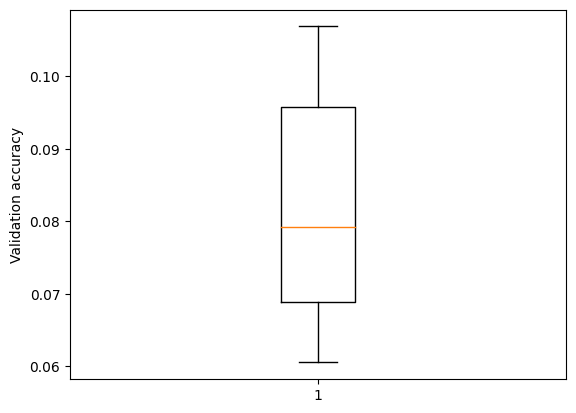

Average accuracy: 0.08
Max accuracy: 0.11
Min accuracy: 0.06


In [ ]:
accuracies = []

for metrics in evaluation.values():
  accuracies.append(metrics[1])

fig = plt.figure()
plt.ylabel('Validation accuracy')
plt.boxplot(accuracies)
plt.show()
print(f"Average accuracy: {np.mean(accuracies):.2f}")
print(f"Max accuracy: {np.max(accuracies):.2f}")
print(f"Min accuracy: {np.min(accuracies):.2f}")

## "Transfer" Learning

- even though the pre-trained weights were not adequate for our specific problem, we can still make use of the architecture. We attempt to train this network from scratch on our data. Since our goal is to build our own VGG16, we are hoping this training will give us a baseline understanding of how the network might behave

In [ ]:
import tensorflow
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras import backend as K

defaultVGG16 = VGG16(weights=None, include_top=False, input_shape=(128,173,3))

flatten = Flatten()
new_layer2 = Dense(10, activation='softmax', name='dense2')

input2 = defaultVGG16.input
output2 = new_layer2(flatten(defaultVGG16.output))

default_VGG16 = Model(input2, output2)
default_VGG16.summary()

Model: "vgg16"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_6 (InputLayer)                                              [(None, 128, 173, 3)]                                       0                      
                                                                                                                                                      
 block1_conv1 (Conv2D)                                             (None, 128, 173, 64)                                        1792                   
                                                                                                                                                      
 block1_conv2 (Conv2D)                                             (None, 128, 

In [ ]:
default_VGG16.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
default_VGG16.save_weights('defaultVGG16.h5')

- expecting the possibility of overfitting, we apply an early stopping callback with a fairly tolerant patience. We will later reduce this patient when we notice the tendency to overfit in some of our convolutional models.
- The hyperparameters chosen here remain the same throughout the rest of the training and are based on earlier experiments made with different models; furthermore, computational capacity ended up being a difficult problem and due to the size of both our models and data running multiple experiments with different parameters on the full scale models was not feasible

In [ ]:
for i in range(len(fold_pointers)-1):
    default_VGG16.load_weights('defaultVGG16.h5')
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('training with fold '+str(i+1)+' as validation')

    train_features_data = np.concatenate((spec_data_channels[:fold_start-1], spec_data_channels[fold_end:]))
    train_label_data = np.concatenate((labels[:fold_start-1], labels[fold_end:]))

    validation_features_data = spec_data_channels[fold_start-1:fold_end]
    validation_label_data = labels[fold_start-1:fold_end]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    default_VGG16.fit(train_features_data, train_label_data, batch_size=128, epochs=30, validation_data = (validation_features_data, validation_label_data), callbacks = [callback], verbose = 1)
    history = default_VGG16.history
    with open('/content/gdrive/MyDrive/'+'defaultVGG16_history'+'_fold'+str(i+1), 'wb') as file:
      model_history= History_trained_model(history.history, history.epoch, history.params)
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

training with fold 1 as validation
Epoch 1/30
62/62 [==============================] - 21s 154ms/step - loss: 3.1894 - accuracy: 0.2109 - val_loss: 2.0789 - val_accuracy: 0.2735
Epoch 2/30
62/62 [==============================] - 6s 97ms/step - loss: 1.6099 - accuracy: 0.4219 - val_loss: 1.4165 - val_accuracy: 0.5011
Epoch 3/30
62/62 [==============================] - 6s 97ms/step - loss: 1.2867 - accuracy: 0.5473 - val_loss: 1.4198 - val_accuracy: 0.5034
Epoch 4/30
62/62 [==============================] - 6s 96ms/step - loss: 1.0237 - accuracy: 0.6465 - val_loss: 1.3619 - val_accuracy: 0.5057
Epoch 5/30
62/62 [==============================] - 6s 96ms/step - loss: 0.8790 - accuracy: 0.7033 - val_loss: 1.3671 - val_accuracy: 0.5526
Epoch 6/30
62/62 [==============================] - 6s 96ms/step - loss: 0.7147 - accuracy: 0.7603 - val_loss: 1.3032 - val_accuracy: 0.5686
Epoch 7/30
62/62 [==============================] - 6s 97ms/step - loss: 0.6045 - accuracy: 0.7981 - val_loss: 1.5824

In [ ]:
with open('/content/gdrive/MyDrive/'+'defaultVGG16_history'+'_fold2', 'rb') as file:
    history=pickle.load(file)

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- we notice immediately that the performance differs significantly between folds: the interval of the validation accuracy is quite large
- we also easily notice that the network is overfitting: having accounted for this issue, we implement an early stopping policy that activated in some cases. This is the same behaviour demonstrated by "our" VGG later on
- due to this fact, further fitting the network will not lead to better performance (in fact, we can see from the plots that the validation loss might not only plateau but actually increase with training epochs)

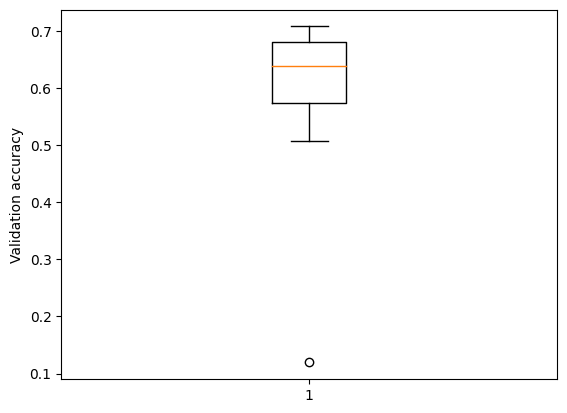

Average accuracy: 0.58
Max accuracy: 0.71
Min accuracy: 0.12


In [ ]:
accuracies = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'defaultVGG16_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  accuracies.append(history.history['val_accuracy'][len(history.history['val_accuracy'])-1])

fig = plt.figure()
plt.ylabel('Validation accuracy')
plt.boxplot(accuracies)
plt.show()
print(f"Average accuracy: {np.mean(accuracies):.2f}")
print(f"Max accuracy: {np.max(accuracies):.2f}")
print(f"Min accuracy: {np.min(accuracies):.2f}")

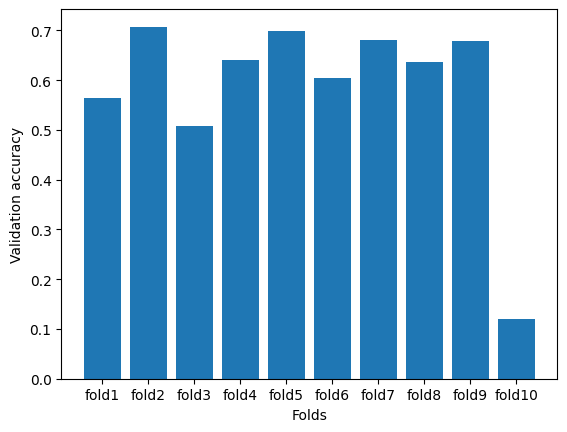

In [ ]:
folds = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'defaultVGG16_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  folds.append('fold'+str(i))

fig = plt.figure()
plt.xlabel('Folds')
plt.ylabel('Validation accuracy')
plt.bar(folds, height = accuracies)
plt.show()

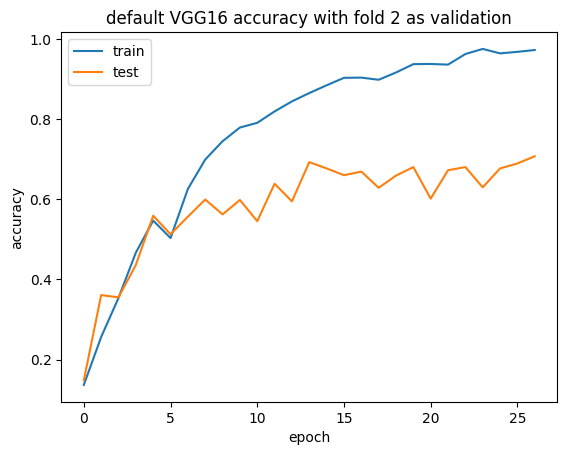

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('default VGG16 accuracy with fold 2 as validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

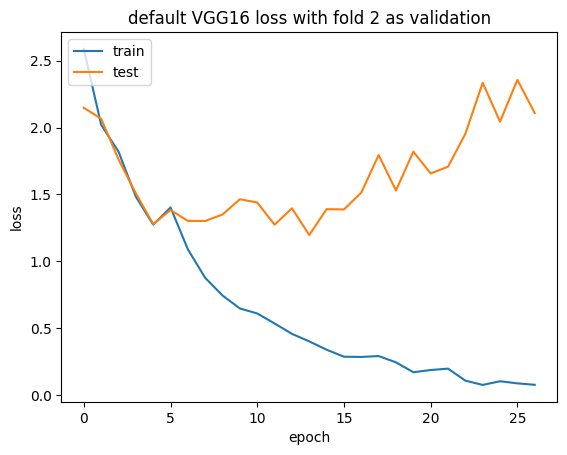

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('default VGG16 loss with fold 2 as validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## VG11 Manual Build

- before defining a VGG16, we test with the smaller VGG11, again, just like the pre-trained model, to get a better understanding of how the network might behave and potential problems we have to account for

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, MaxPool2D, BatchNormalization
from keras.optimizers import Adam


X_input = Input(shape=(128, 173, 3))
X = Conv2D (64, kernel_size=3, padding ='same', activation='relu')(X_input)
X = MaxPool2D(pool_size=2, strides=2, padding ='same')(X)
X = Conv2D (128, kernel_size=3, padding ='same')(X)
X = BatchNormalization()(X) # Regularization technique
X = Activation('relu')(X)
X = MaxPool2D(pool_size=2, strides=2, padding ='same')(X)

X = Conv2D (256, kernel_size=3, padding ='same')(X)
X = Conv2D (256, kernel_size=3, padding ='same')(X)
X = BatchNormalization()(X) # Regularization technique
X = Activation('relu')(X)
X = MaxPool2D(pool_size=2, strides=2, padding ='same')(X)

X = Conv2D (512, kernel_size=3, padding ='same')(X)
X = Conv2D (512, kernel_size=3, padding ='same')(X)
X = BatchNormalization()(X) # Regularization technique
X = Activation('relu')(X)
X = MaxPool2D(pool_size=2, strides=2, padding ='same')(X)

X = Conv2D (512, kernel_size=3, padding ='same')(X)
X = Conv2D (512, kernel_size=3, padding ='same')(X)
X = BatchNormalization()(X) # Regularization technique
X = Activation('relu')(X)
X = MaxPool2D(pool_size=2, strides=2, padding ='same')(X)

# 3 fully connected layers
X = Flatten()(X)
X = Dense(4096, activation ='relu')(X)
X = Dropout(0.5)(X) # Regularization technique
X = Dense(4096, activation ='relu')(X)
X = Dense(10, activation ='softmax')(X)
modelVGG11 = Model(inputs=X_input, outputs=X, name="VGG11")

In [ ]:
modelVGG11.summary()

Model: "VGG11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 173, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 173, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 87, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 87, 128)       73856     
                                                                 
 batch_normalization (Batch  (None, 64, 87, 128)       512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 87, 128)       0     

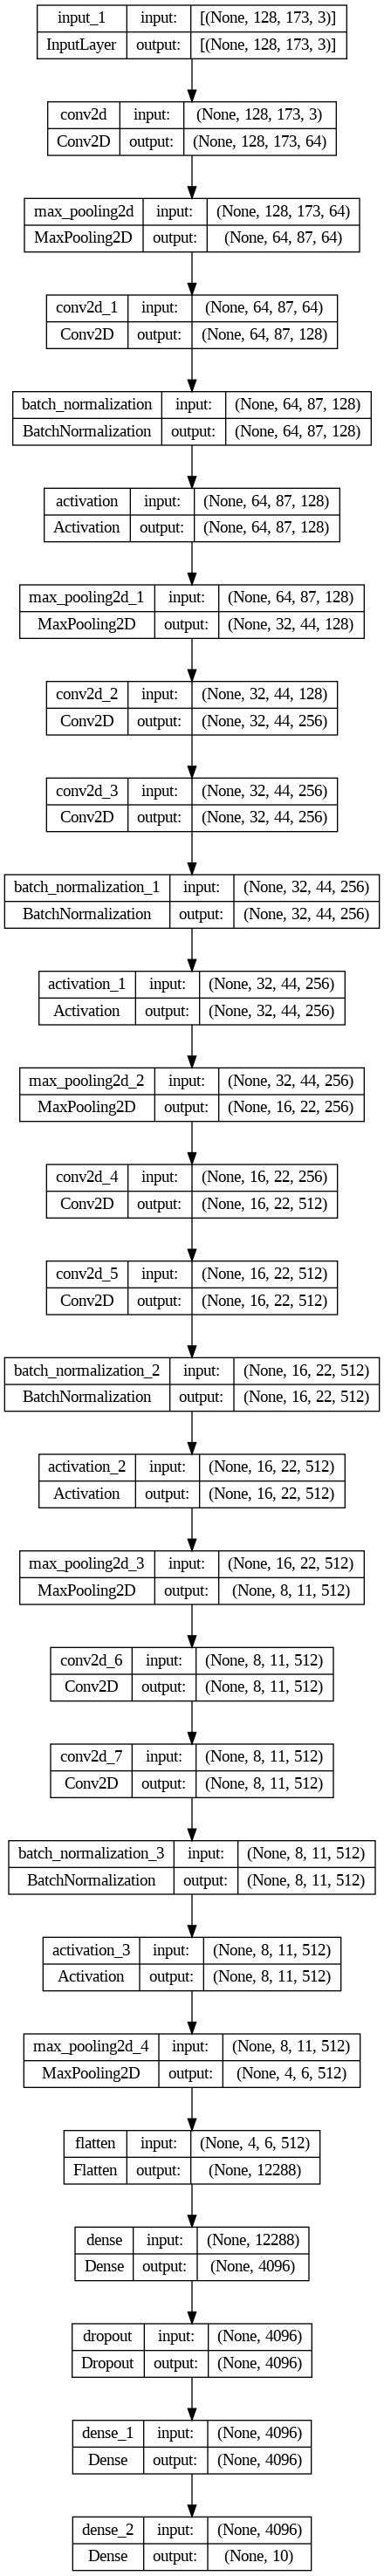

In [ ]:
tf.keras.utils.plot_model(modelVGG11, show_shapes=True)

In [ ]:
modelVGG11.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
modelVGG11.save_weights('VGG11_default.h5')

In [ ]:
for i in range(len(fold_pointers)-1):
    modelVGG11.load_weights('VGG11_default.h5')
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('training with fold '+str(i+1)+' as validation')

    train_features_data = np.concatenate((spec_data_channels[:fold_start-1], spec_data_channels[fold_end:]))
    train_label_data = np.concatenate((labels[:fold_start-1], labels[fold_end:]))

    validation_features_data = spec_data_channels[fold_start-1:fold_end]
    validation_label_data = labels[fold_start-1:fold_end]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    modelVGG11.fit(train_features_data, train_label_data, batch_size=128, epochs=30, validation_data = (validation_features_data, validation_label_data), callbacks = [callback], verbose = 1)
    history = modelVGG11.history
    with open('/content/gdrive/MyDrive/'+'VGG11_history'+'_fold'+str(i+1), 'wb') as file:
      model_history= History_trained_model(history.history, history.epoch, history.params)
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

training with fold 1 as validation
Epoch 1/30
62/62 [==============================] - 21s 204ms/step - loss: 4.6091 - accuracy: 0.1483 - val_loss: 3.0436 - val_accuracy: 0.1693
Epoch 2/30
62/62 [==============================] - 4s 70ms/step - loss: 2.1835 - accuracy: 0.1727 - val_loss: 2.1811 - val_accuracy: 0.1945
Epoch 3/30
62/62 [==============================] - 4s 71ms/step - loss: 2.1806 - accuracy: 0.1758 - val_loss: 2.1783 - val_accuracy: 0.1979
Epoch 4/30
62/62 [==============================] - 4s 70ms/step - loss: 2.1592 - accuracy: 0.1718 - val_loss: 2.1501 - val_accuracy: 0.2071
Epoch 5/30
62/62 [==============================] - 4s 70ms/step - loss: 2.1431 - accuracy: 0.1874 - val_loss: 2.0730 - val_accuracy: 0.2529
Epoch 6/30
62/62 [==============================] - 4s 70ms/step - loss: 2.0863 - accuracy: 0.2052 - val_loss: 2.0923 - val_accuracy: 0.2300
Epoch 7/30
62/62 [==============================] - 4s 70ms/step - loss: 2.0682 - accuracy: 0.2172 - val_loss: 2.0429

- the interesting conclusion here is that the VGG11 performs quite worse than the VGG16 (which is in part to be expected just due to the fact that it is a smaller network)
- however, we do not see the same overfitting tendency shown in the previous VGG, meaning that perhaps we could obtain an even better performance with more training time on this network

In [ ]:
with open('/content/gdrive/MyDrive/'+'VGG11_history'+'_fold1', 'rb') as file:
    history=pickle.load(file)

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


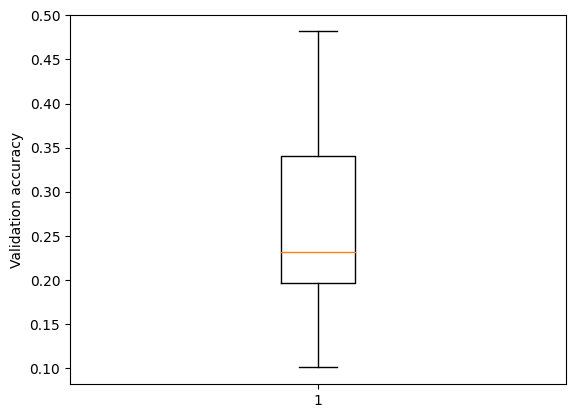

Average accuracy: 0.27
Max accuracy: 0.48
Min accuracy: 0.10


In [ ]:
accuracies = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'VGG11_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  accuracies.append(history.history['val_accuracy'][len(history.history['val_accuracy'])-1])

fig = plt.figure()
plt.ylabel('Validation accuracy')
plt.boxplot(accuracies)
plt.show()
print(f"Average accuracy: {np.mean(accuracies):.2f}")
print(f"Max accuracy: {np.max(accuracies):.2f}")
print(f"Min accuracy: {np.min(accuracies):.2f}")

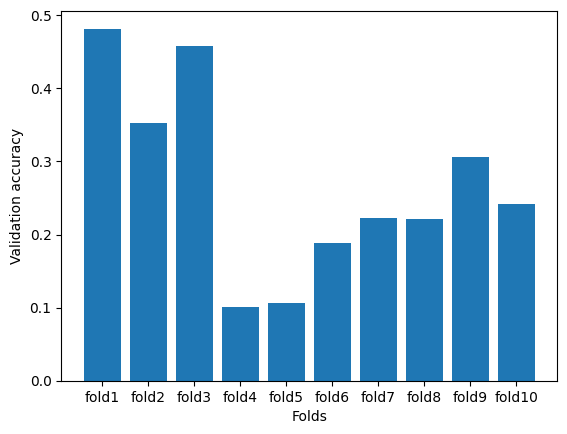

In [ ]:
folds = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'VGG11_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  folds.append('fold'+str(i))

fig = plt.figure()
plt.xlabel('Folds')
plt.ylabel('Validation accuracy')
plt.bar(folds, height = accuracies)
plt.show()

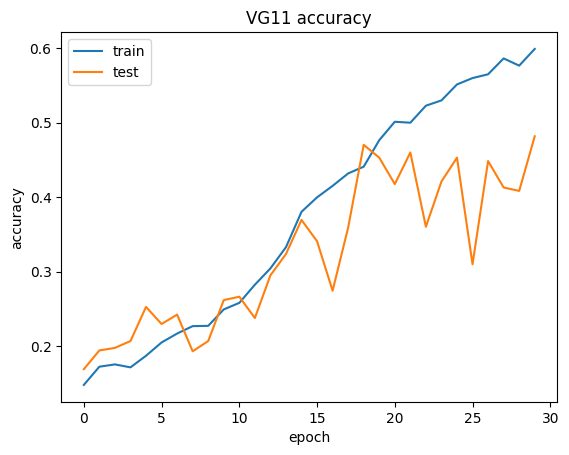

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VG11 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

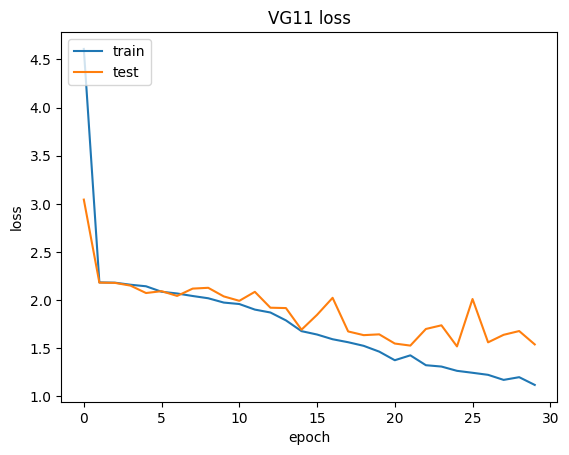

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VG11 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

## VGG16 Manual Build

- Finally, we manually define a VGG16 network. It differs from the pre-trained model on some parameters such as each layer's filters and also gives us more control over each part of the network, being able to remove and add layers, change functions, etc.
- Overall, it follows the same logic: 5 blocks of convolutional layers with ascending filters and max pooling at the end of each block and a group of fully connected layers at the end. The output is a 10-probability vector with a softmax activation function

In [ ]:
#full VGG16

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, MaxPool2D
from keras.optimizers import Adam
#from keras.utils import np_utils
from sklearn import metrics


input = Input(shape = (128,173,3))


#block 1
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)# 2nd Conv Block

#block 2
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)# 3rd Conv block

#block 3
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)# 4th Conv block

#block 4
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

#block 5
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)# Fully connected layers

#output
x = Flatten()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 10, activation ='softmax')(x)# creating the model

modelVGG16 = Model (inputs=input, outputs = output, name = 'VGG16')
modelVGG16.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 173, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 173, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 173, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 87, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 87, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 87, 128)       147584    
                                                             

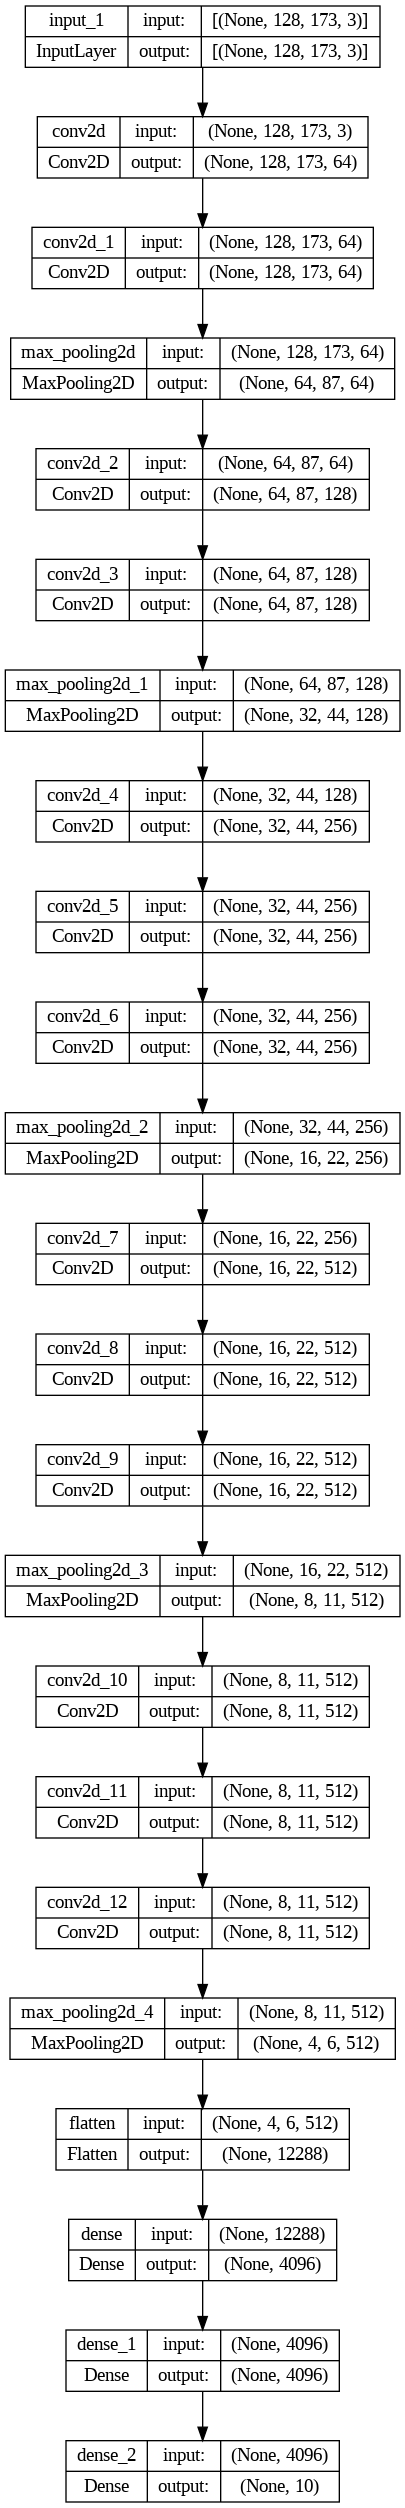

In [ ]:
tf.keras.utils.plot_model(modelVGG16, show_shapes=True)

In [ ]:
modelVGG16.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
modelVGG16.save_weights('VGG16.h5')

- We verifiy the same overfitting tendency that the pre-trained model had
- We see a wider range of validation accuracies but overall a greater average validation accuracy

In [ ]:
for i in range(len(fold_pointers)-1):
    modelVGG16.load_weights('VGG16.h5')
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('training with fold '+str(i+1)+' as validation')

    train_features_data = np.concatenate((spec_data_channels[:fold_start-1], spec_data_channels[fold_end:]))
    train_label_data = np.concatenate((labels[:fold_start-1], labels[fold_end:]))

    validation_features_data = spec_data_channels[fold_start-1:fold_end]
    validation_label_data = labels[fold_start-1:fold_end]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    modelVGG16.fit(train_features_data, train_label_data, batch_size=128, epochs=30, validation_data = (validation_features_data, validation_label_data), callbacks = [callback], verbose = 1)
    history = modelVGG16.history
    with open('/content/gdrive/MyDrive/'+'VGG16_history'+'_fold'+str(i+1), 'wb') as file:
      model_history= History_trained_model(history.history, history.epoch, history.params)
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)
    modelVGG16.save_weights('VGG16weights_fold' + str(i+1) + '.h5')


training with fold 1 as validation
Epoch 1/30
62/62 [==============================] - 14s 135ms/step - loss: 4.1544 - accuracy: 0.1569 - val_loss: 2.1524 - val_accuracy: 0.1579
Epoch 2/30
62/62 [==============================] - 7s 105ms/step - loss: 1.7939 - accuracy: 0.3347 - val_loss: 1.9012 - val_accuracy: 0.3284
Epoch 3/30
62/62 [==============================] - 7s 105ms/step - loss: 1.3098 - accuracy: 0.5236 - val_loss: 1.4811 - val_accuracy: 0.4554
Epoch 4/30
62/62 [==============================] - 7s 105ms/step - loss: 1.0913 - accuracy: 0.6051 - val_loss: 1.2447 - val_accuracy: 0.5389
Epoch 5/30
62/62 [==============================] - 6s 104ms/step - loss: 0.8985 - accuracy: 0.6886 - val_loss: 1.3330 - val_accuracy: 0.5824
Epoch 6/30
62/62 [==============================] - 6s 104ms/step - loss: 0.7421 - accuracy: 0.7380 - val_loss: 1.2323 - val_accuracy: 0.6007
Epoch 7/30
62/62 [==============================] - 6s 104ms/step - loss: 0.6814 - accuracy: 0.7608 - val_loss: 

In [ ]:
with open('/content/gdrive/MyDrive/'+'VGG16_history'+'_fold1', 'rb') as file:
    history=pickle.load(file)

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


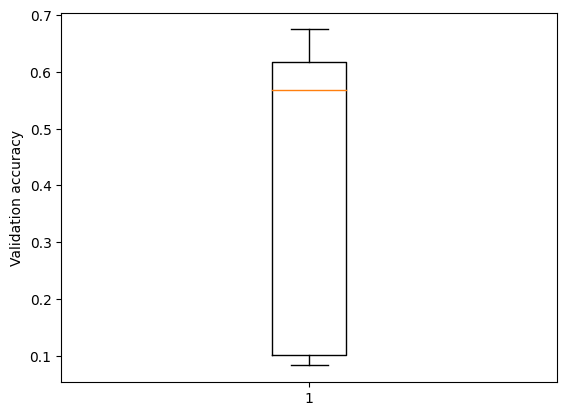

Average accuracy: 0.41
Max accuracy: 0.67
Min accuracy: 0.08


In [ ]:
accuracies = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'VGG16_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  accuracies.append(history.history['val_accuracy'][len(history.history['val_accuracy'])-1])

fig = plt.figure()
plt.ylabel('Validation accuracy')
plt.boxplot(accuracies)
plt.show()
print(f"Average accuracy: {np.mean(accuracies):.2f}")
print(f"Max accuracy: {np.max(accuracies):.2f}")
print(f"Min accuracy: {np.min(accuracies):.2f}")

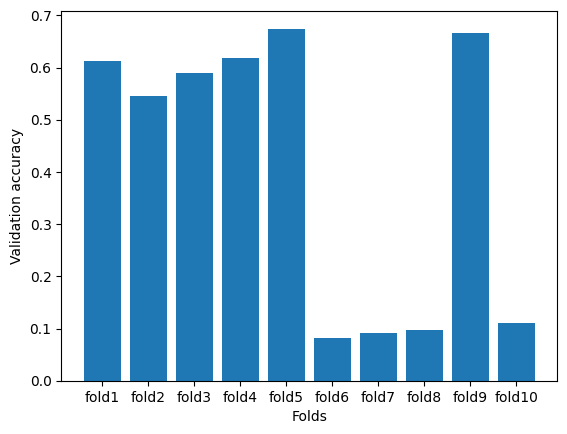

In [ ]:
folds = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'VGG16_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  folds.append('fold'+str(i))

fig = plt.figure()
plt.xlabel('Folds')
plt.ylabel('Validation accuracy')
plt.bar(folds, height = accuracies)
plt.show()

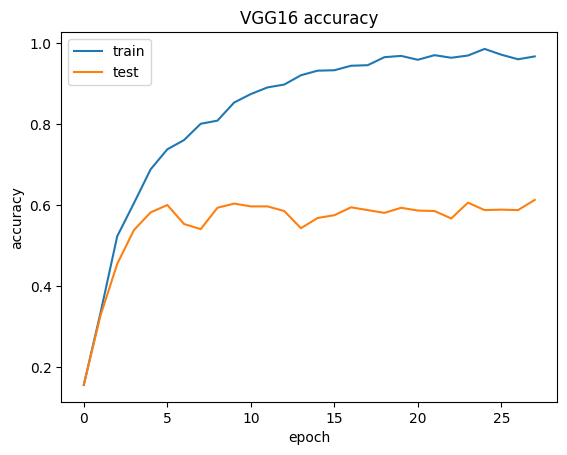

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

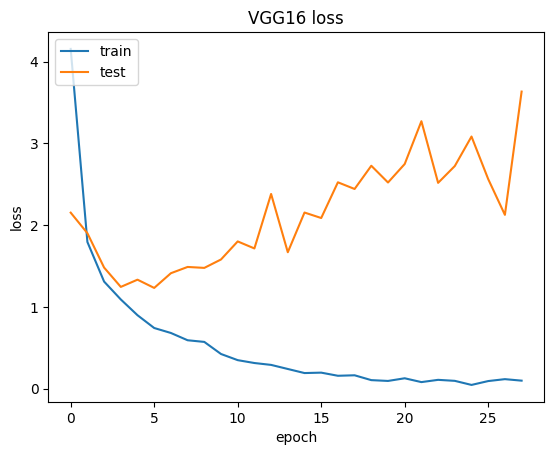

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

A possible next step would be to implement regularization metrics to try and prevent this overfitting behavior

#VGG11 Training Experiment

- like mentioned before, the VGG11 network displayed potential to perform better, displaying a clear descending curve on both validation loss and accuracy. For this reason, we attempt to further train our network and more accurately test it's result.
- during this training, we constrict the patience parameter on our callback, being aware of the tendency of the model to overfit

In [ ]:
#with same VGG11 as before

for i in range(len(fold_pointers)-1):
    modelVGG11.load_weights('VGG11_default.h5')
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('training with fold '+str(i+1)+' as validation')

    train_features_data = np.concatenate((spec_data_channels[:fold_start-1], spec_data_channels[fold_end:]))
    train_label_data = np.concatenate((labels[:fold_start-1], labels[fold_end:]))

    validation_features_data = spec_data_channels[fold_start-1:fold_end]
    validation_label_data = labels[fold_start-1:fold_end]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

    modelVGG11.fit(train_features_data, train_label_data, batch_size=32, epochs=100, validation_data = (validation_features_data, validation_label_data), callbacks = [callback], verbose = 1)
    history = modelVGG11.history
    with open('/content/gdrive/MyDrive/'+'VGG11_second_history'+'_fold'+str(i+1), 'wb') as file:
      model_history= History_trained_model(history.history, history.epoch, history.params)
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

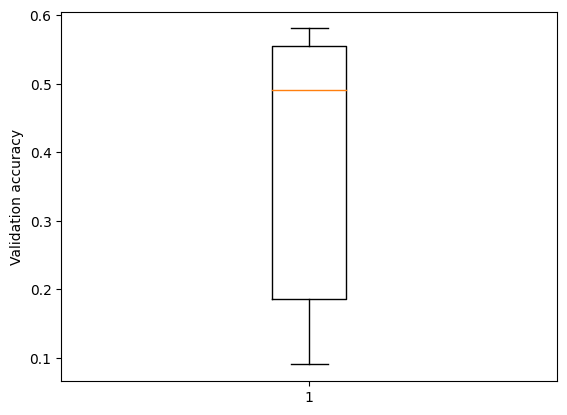

Average accuracy: 0.38
Max accuracy: 0.58
Min accuracy: 0.09


In [9]:
accuracies = []

for i in range(1, 8):
  with open('/content/gdrive/MyDrive/'+'VGG11_second_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  accuracies.append(history.history['val_accuracy'][len(history.history['val_accuracy'])-1])

fig = plt.figure()
plt.ylabel('Validation accuracy')
plt.boxplot(accuracies)
plt.show()
print(f"Average accuracy: {np.mean(accuracies):.2f}")
print(f"Max accuracy: {np.max(accuracies):.2f}")
print(f"Min accuracy: {np.min(accuracies):.2f}")

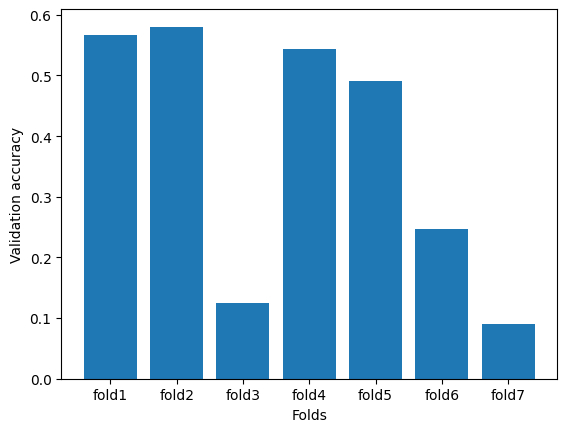

In [10]:
folds = []

for i in range(1, 8):
  with open('/content/gdrive/MyDrive/'+'VGG11_second_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  folds.append('fold'+str(i))

fig = plt.figure()
plt.xlabel('Folds')
plt.ylabel('Validation accuracy')
plt.bar(folds, height = accuracies)
plt.show()

In [11]:
with open('/content/gdrive/MyDrive/'+'VGG11_second_history'+'_fold2', 'rb') as file:
    history=pickle.load(file)

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


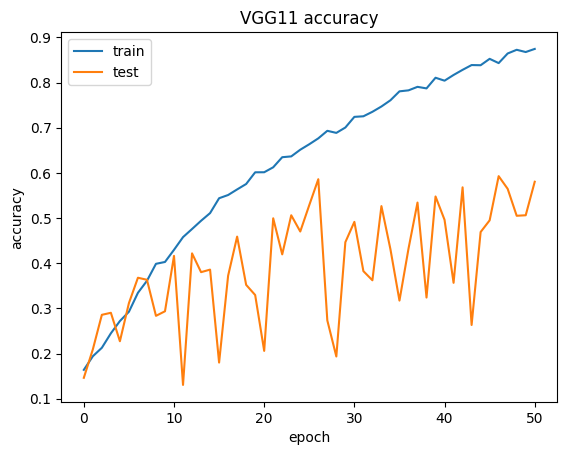

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG11 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

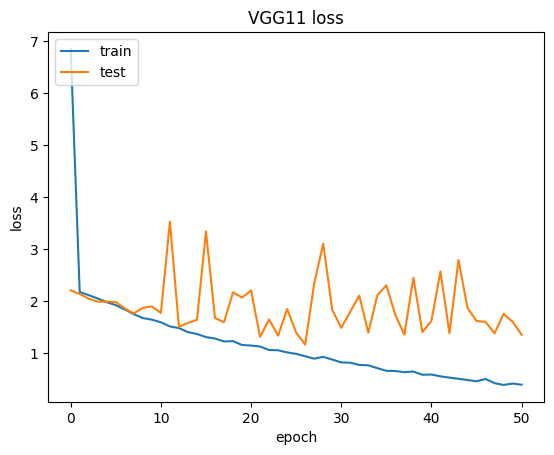

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG11 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Not only do we verify the same overfitting tendency, we see big fluctuations in both validation loss and accuracy: this means that the model is very sensitive to noise and is essentially classifying some examples randomly
- safe to say our experiment with the VGG11 was unsuccessful and that this network is not as good as it's bigger counterpart at generalizing the data

## **Model Selection and Optimization**

- having experimented with different models, we decided to focus our attention of the VGG16 model defined in the the tensorflow 'applications' package
- this network seemed to offer the best tradeoff between model complexity and performance. Therefore, we selected this model for further training and optimization in an attempt to solve the overfitting tendency and increase it's performance by further tuning it's hyperparameters.

In [20]:
import tensorflow
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras import backend as K

imagenet_weights = VGG16(weights='imagenet', include_top=False, input_shape=(128,173,3))
imagenet_weights.summary(line_length=150)

flatten = Flatten()
new_layer2 = Dense(10, activation='softmax', name='dense2')

input2 = imagenet_weights.input
output2 = new_layer2(flatten(imagenet_weights.output))

tuning_VGG16 = Model(input2, output2)
tuning_VGG16.summary()

Model: "vgg16"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_3 (InputLayer)                                              [(None, 128, 173, 3)]                                       0                      
                                                                                                                                                      
 block1_conv1 (Conv2D)                                             (None, 128, 173, 64)                                        1792                   
                                                                                                                                                      
 block1_conv2 (Conv2D)                                             (None, 128, 

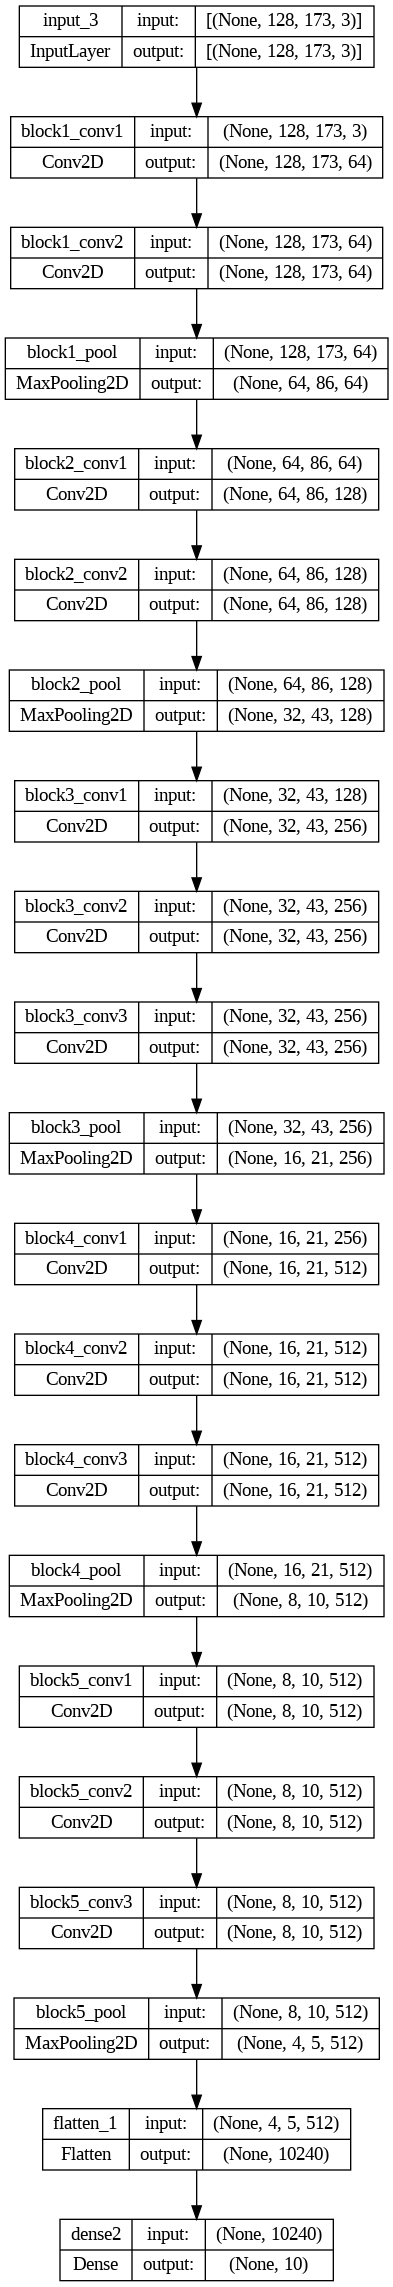

In [22]:
tf.keras.utils.plot_model(tuning_VGG16, show_shapes = True)

- to test the networks performance using different parameters we use the 'keras_tuner' function, which takes as input another 'build_model' function; the tuner builds the desired model with different combinations starting hyperparameters and then trains and tests that model on the desired data over a given number of iterations, storing the best possible combination for the target variable (usually validation accuracy)
- in our case, we iterate over different values of units in the first fully connected layer of that would compose our output and different values for the learning rate
- given the overfitting tendency we observed earlier, perhaps an adjustement of the learning rate would enable the model to further progress in reducing validation loss

In [ ]:
!pip install keras_tuner

In [17]:
import tensorflow
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.optimizers import Adam

def build_model(hp):

  defaultVGG16 = VGG16(weights=None, include_top=False, input_shape=(128,173,3))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  flatten = Flatten()
  new_layer1 = Dense(units = hp_units, activation = 'relu', name = 'dense1')
  new_layer2 = Dense(10, activation = 'softmax', name = 'dense2')

  input2 = defaultVGG16.input
  output2 = new_layer2(new_layer1(flatten(defaultVGG16.output)))

  tuning_VGG16 = Model(input2, output2)


  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  print(tuning_VGG16.summary())
  tuning_VGG16.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate=hp_learning_rate))
  tuning_VGG16.save_weights('tuningVGG.h5')
  return tuning_VGG16

In [18]:
import keras_tuner as kt

model_tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


**due to constraints regarding both time and computational capacity, unfortunately, we were not able to perform the full hyperparameter search and neither the training of the tuned model. Due to the fact that our models were quite large, the work in regards to training and evaluating different models was highly limited by these constraints**

In [25]:
#hyperparameter k-fold search
for i in range(len(fold_pointers)-1):
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('searching with fold '+str(i+1)+' as validation')

    train_features_data = np.concatenate((spec_data_channels[:fold_start-1], spec_data_channels[fold_end:]))
    train_label_data = np.concatenate((labels[:fold_start-1], labels[fold_end:]))

    validation_features_data = spec_data_channels[fold_start-1:fold_end]
    validation_label_data = labels[fold_start-1:fold_end]

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    model_tuner.search(train_features_data, train_label_data, batch_size=128, epochs=100, validation_data = (validation_features_data, validation_label_data), callbacks = [callback], verbose = 1)
    best_hps=model_tuner.get_best_hyperparameters(num_trials=1)[0]

    optimal_units = best_hps.get('units')
    optimal_lr = best_hps.get('learning_rate')

    with open('/content/gdrive/MyDrive/'+'tuning_units'+'_fold'+str(i+1), 'wb') as file:
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)
    with open('/content/gdrive/MyDrive/'+'tuning_lr'+'_fold'+str(i+1), 'wb') as file:
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

Trial 26 Complete [00h 05m 00s]
val_accuracy: 0.6327230930328369

Best val_accuracy So Far: 0.6475972533226013
Total elapsed time: 01h 06m 22s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
512               |192               |units
0.01              |0.001             |learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 173, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 173, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 173, 64)      36

62/62 [==============================] - 47s 701ms/step - loss: 11896088.0000 - accuracy: 0.1120 - val_loss: 2.2572 - val_accuracy: 0.1144
Epoch 2/10
44/62 [====================>.........] - ETA: 11s - loss: 2.2668 - accuracy: 0.1136

KeyboardInterrupt: ignored

In [22]:
opt_lr = 0.1
opt_units = 192

now building the network with optimal parameters:

In [23]:
default_model = VGG16(weights=None, include_top=False, input_shape=(128,173,3))

flatten = Flatten()
new_layer1 = Dense(units = opt_units, activation = 'relu', name = 'dense1')
new_layer2 = Dense(10, activation = 'softmax', name = 'dense2')


first_dense = new_layer1(flatten(default_model.output))
input2 = default_model.input
output2 = new_layer2(first_dense)

opt_model = Model(input2, output2)

opt_model.summary()
opt_model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate=opt_lr))
opt_model.save_weights('tuningVGG.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 173, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 173, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 173, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 86, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 86, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 86, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 43, 128)       0   

In [25]:
for i in range(len(fold_pointers)-1):
    opt_model.load_weights('tuningVGG.h5')
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('training with fold '+str(i+1)+' as validation')

    train_features_data = np.concatenate((spec_data_channels[:fold_start-1], spec_data_channels[fold_end:]))
    train_label_data = np.concatenate((labels[:fold_start-1], labels[fold_end:]))

    validation_features_data = spec_data_channels[fold_start-1:fold_end]
    validation_label_data = labels[fold_start-1:fold_end]

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    opt_model.fit(train_features_data, train_label_data, batch_size=128, epochs=30, validation_data = (validation_features_data, validation_label_data), callbacks = [early_stopping], verbose = 1)
    history = opt_model.history
    with open('/content/gdrive/MyDrive/'+'opt_model_history'+'_fold'+str(i+1), 'wb') as file:
      model_history= History_trained_model(history.history, history.epoch, history.params)
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

training with fold 1 as validation
Epoch 1/30
62/62 [==============================] - 51s 821ms/step - loss: nan - accuracy: 0.1134 - val_loss: nan - val_accuracy: 0.1125
Epoch 2/30
62/62 [==============================] - 50s 810ms/step - loss: nan - accuracy: 0.1146 - val_loss: nan - val_accuracy: 0.1125
Epoch 3/30
62/62 [==============================] - 51s 817ms/step - loss: nan - accuracy: 0.1146 - val_loss: nan - val_accuracy: 0.1125
training with fold 2 as validation
Epoch 1/30


ResourceExhaustedError: ignored